# Problem 1

Consider the nonlinear regression model,

$$y_i = m(x_i) + \sigma \epsilon_i, \hspace{5 mm} i = 1,2 , ..., n,$$

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bokeh
from bokeh.plotting import figure, show
from bokeh.models import ranges
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### Read Data

In [2]:
df = pd.read_csv('data.csv')
df = pd.read_csv('data.csv')
df.sort_values(by = 'x', inplace = True)
xi = df.x.values
yi = df.y.values

### Plot Data

In [3]:
p = figure(width = 500, height = 300)
p.scatter(x= xi.flatten(), y= yi.flatten(), color = 'black', size = 6)
show(p)

1) Using the uniform kernel find the estimator of $m(0)$

In [4]:
def uniform_kernel(xi, yi, x, h):
    """Returns the estimator at x for a uniform kernel with a
    given smoothing parameter h"""
    
    # Nearest Neighbors - 1s and 0s
    t = abs(xi - x)     
    n_neighbors = (t<=h).sum()
    
    # Apply weights
    wi  = np.where(t<=h, 1/n_neighbors ,0)   
    
    #Nadaraya-Watson estimator
    y_pred = np.sum(wi*yi)
        
    return y_pred

Check Kernel over all data points

In [5]:
y_pred = []
for xo in xi:
    y_pred.append(uniform_kernel(xi, yi, xo, 0.1))

In [6]:
p = figure(width = 500, height = 300)
p.scatter(x= xi.flatten(), y= yi.flatten(), color = 'black', size = 6)
p.line(x= xi, y =y_pred,  line_color = 'red', line_width = 1.5 )
show(p)

In [7]:
mo = uniform_kernel(xi, yi, 0, h = 0.1)
mo

-0.11111796963636364

2) Write down an expression for and hence find the value of the bias of $\hat m(0)$ if the
true function $m(x)$ is linear with slope $1.2$

$$\large (1) \hspace{5 mm} E \hat m(x) = m(x) + \dfrac{\Sigma_{|x-x_i|<h} (m(x_i) - m(x))}{\Sigma_{|x-x_i|<h} 1}$$

Using a Taylor Expansion

$$\large m(x_i) = m(x) + (x_i - x) m'(x) + \dfrac{1}{2}(x_i - x)^2 m''(x) + o(h^2)$$

Thus

$$\large E \hat m(x) - m(x) = $$

$$\large m'(x)\dfrac{\Sigma_{|x-x_i|<h} ( x_i - x)}{\Sigma_{|x-x_i|<h} 1} +
\dfrac{1}{2}m''(x)\dfrac{\Sigma_{|x-x_i|<h} ( x_i - x)^2}{\Sigma_{|x-x_i|<h} 1}
$$

$$\text{where} $$

$$m'(x) = 1.2 \\
m''(x) = 0
$$

So

$$\large (2) \hspace{5 mm} E \hat m(x) - m(x) = \large 1.2\dfrac{\Sigma_{|x-x_i|<h} ( x_i - x)}{\Sigma_{|x-x_i|<h} 1}$$

Using $(1)$

In [8]:
# Short function for clarity
m = lambda x: 1.2*x

h = 0.1
x = 0
# Nearest Neighbors - 1s and 0s
t = abs(xi - x)     
denominator = (t<=h).sum()

# Apply weights
numerator  = np.sum(np.where(t<=h, m(xi)- m(x) ,0)) 

bias = m(x) + (numerator/denominator)
print('Bias =', bias)

Bias = -0.030515620690909087


Using $(2)$

In [9]:
h = 0.1
x = 0
# Nearest Neighbors - 1s and 0s
t = abs(xi - x)     
denominator = (t<=h).sum()

# Apply weights
numerator  = np.sum(np.where(t<=h, xi-x ,0)) 

bias = 1.2 *(numerator/denominator)
print('Bias =', bias)

Bias = -0.030515620690909087


3) What is the variance of $\hat m(0)$? Leave your answer in terms of the unknown $\sigma^2$

$$\large Var \hspace{1 mm} \hat m(x)\hspace{2 mm} = \sigma ^2 \Sigma_{i=1}^n 
w_{i,h}^2 (x)$$

In [10]:
x = 0
h = 0.1
t = abs(xi - x)     
n_neighbors = (t<=h).sum()

# # Apply weights
wi  = np.where(t<=h, 1/n_neighbors ,0)
np.sum(wi**2)

0.09090909090909091

$$\large Var \hspace{1 mm} \hat m(x)\hspace{2 mm} = 0.09090 \cdot \sigma ^2 $$

4) Without actually calculating the variance, write down an expression for estimating $\sigma^2$

$$\hat\sigma ^2  = \dfrac{\Sigma_{i=1}^n (y_i - \hat m(x_i))^2}{n-p} = \dfrac{\Sigma_{i=1}^n (y_i - \hat m(x_i))^2}{n-1}
$$

$$\text{where} $$

$$ p \hspace{2 mm} \text{is the number of parameters.} $$

5) If the true value of $\sigma$ is known to be 0.1, find the 95% confidence interval for
the predictive value of $y$ at $x = 0$.

In [11]:
z = 1.96
sigma = 0.1

In [12]:
y_pred = uniform_kernel(xi, yi, 0, h = 0.1)
y_pred

-0.11111796963636364

In [13]:
variance_m_0 = 0.09090 * sigma**2

In [14]:
CI_error = z * np.sqrt(variance_m_0)
CI_error

0.05909326865219083

In [15]:
m_at_0_UP = y_pred + CI_error
m_at_0_DO = y_pred - CI_error

print(m_at_0_UP , m_at_0_DO)

-0.052024700984172806 -0.17021123828855447


$$ 95\% \hspace{2 mm} CI = (-0.0520 \hspace{2 mm}\text{to}\hspace{2 mm} -0.17021) $$

# Problem 2

In [16]:
df = pd.read_csv('data.csv')
df.sort_values(by = 'x', inplace = True)
xi = df.x.values
yi = df.y.values

Splitting Function

In [17]:
def calculate_error(x, y, r):
    """
    Partitions an array based on split term r and computes the error between
    the two newly formed segments.  
    """
    # Obtain Subsets
    r_filter = x <= r
    partition_1 = y[r_filter]
    partition_2 = y[~r_filter]
    
    # Compute the average for each subset
    m1_hat = np.mean(partition_1)
    m2_hat = np.mean(partition_2)
    T = np.sum((partition_1 - m1_hat)**2) + \
        np.sum((partition_2 - m2_hat)**2)
    
    return T, m1_hat, m2_hat

def get_split_point(x, y):
    """Returns the split value and index in a segment that 
    minimizes the error. Splits segment in two.
    
    Examples:
        y = np.array([0,0,0,0,0,0,0,3,3,3])
        x = np.arange(0,len(y))
        print(get_split_point(x,y))
        >>> (6, 6)
        
        y = np.array([3,3,-4,-4,-4,-4,-4,-4,-4,-4])
        print(get_split_point(x,y))
        >>> (1,1))
    """

    T_r = []
    # Iterate over all possible partitions
    for idx in range(len(x)):

        # For each partition calculate error
        T, _, _ =calculate_error(x, y, x[idx])        
        T_r.append(T)
        
    T_r = np.array(T_r)
    return x[np.argmin(T_r)]

Testing Splitting Function

In [30]:
y = np.array([0,0,0,0,0,0,0,3,3,3])
x = np.arange(0,len(y))
assert get_split_point(x,y) == 6

y = np.array([3,3,-4,-4,-4,-4,-4,-4,-4,-4])
assert get_split_point(x,y) == 1

1) Find the optimal choice of r which minimizes the sum of square errors. Show
your working and algorithm.

In [19]:
split_point = get_split_point(xi,yi)
print('Optimal choice of r is', split_point)

Optimal choice of r is 0.104154397


In [20]:
p = figure(width = 500, height = 300)
p.scatter(x= xi, y= yi, color = 'black', size = 6,legend_label = 'data')
p.legend.location = 'top_left'
p.y_range = ranges.Range1d(start = -1.5, end = 1.5)
p.line(x = split_point, y = [-10,10], color = 'navy', legend_label = 'split_point' )
show(p)

2) What is your result from (1)? State your optimal choice of r and $\hat m(x)$ function.

In [21]:
print('Optimal choice of r is', split_point)

Optimal choice of r is 0.104154397


In [22]:
T, m1_hat, m2_hat = calculate_error(xi, yi, split_point)
print('m1_j:', m1_hat)
print('m2_j:', m2_hat)

m1_j: -0.6377018859259259
m2_j: 0.8667163272608694


\begin{align}
\hat m(x) &= \begin{cases}
-0.63770,  \text{ if } x  \leq r \\
0.86671,  \text{ if } x > r
\end{cases} \\
\\
&= \begin{cases}
-0.63770,  \text{ if } x  \leq 0.10415 \\
0.86671,  \text{ if } x > 0.10415
\end{cases}
\end{align}

3) What is the predictive value for the y corresponding to x = 0.5?

$$\hat m(0.5) = 0.86671 $$

4) Using the non-parametric bootstrap, find an estimator for the variance of $\hat m(0.5)$.
Provide all your working.

In [23]:
m1_hat = []
m2_hat = []
m_at_05 = []
for _ in range(1000):
    
    # Sample with replacement 100 (x,y) pairs
    idx = np.random.choice(len(df), size=100, replace=True)
    x_arr = xi[idx]
    y_arr = yi[idx]    
        
    r_iter = get_split_point(x_arr, y_arr)
    T, m1_iter, m2_iter = calculate_error(x_arr, y_arr, r_iter)
    m1_hat.append(m1_iter)
    m2_hat.append(m2_iter)
    if 0.5 > r_iter:
        m_at_05.append(m2_iter)
    else:
        m_at_05.append(m1_iter)

In [24]:
def plot_hist(x, name, label_position):
    plt.hist(x, bins=12, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(label_position, max_ylim*0.9, 'Mean: {:.4f}'.format(x.mean()))
    plt.xlabel(name); # plt.xlim(0.90,1.05); 
    plt.show()

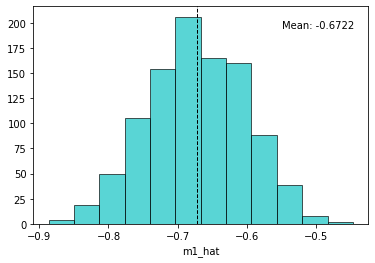

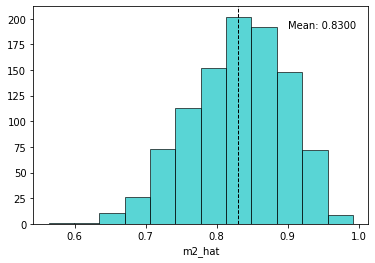

In [25]:
plot_hist(np.array(m1_hat), 'm1_hat', -0.55)
plot_hist(np.array(m2_hat), 'm2_hat', 0.9)

In [26]:
print('Variance m1_hat:' ,np.array(m1_hat).var(ddof = 1))
print('Variance m2_hat:' ,np.array(m2_hat).var(ddof = 1))
print('Variance m_hat_05:' ,np.array(m_at_05).var(ddof = 1))

Variance m1_hat: 0.004972396991597736
Variance m2_hat: 0.004578391323395216
Variance m_hat_05: 0.004578391323395216


$$Var \hspace{2 mm} \hat m(0.5) = Var \hspace{2 mm} \hat m_1  = 0.004283$$

5) Using the answer to part (4), construct a 95% confidence interval for $\hat m(0.5)$.

In [27]:
y_pred = np.mean(np.array(m_at_05))
y_pred

0.829983089222963

In [28]:
CI_error = 1.96 * np.std( np.array(m_at_05), ddof = 1)
CI_error

0.13262106962302433

In [29]:
m_at_05_UP = y_pred + CI_error
m_at_05_DO = y_pred - CI_error

print(m_at_05_UP , m_at_05_DO)

0.9626041588459874 0.6973620195999387


$$ 95\% \hspace{2 mm} CI = (0.705894 \hspace{2 mm}\text{to}\hspace{2 mm} 0.96244) $$